In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
# from category_encoders import OrdinalEncoder
from IPython.display import VimeoVideo
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import mean_absolute_error
from ipywidgets import Dropdown, FloatSlider, IntSlider, interact
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression, Ridge 
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.metrics import make_scorer, r2_score

In [2]:
df = pd.read_excel("../data/nEW d DATA.xlsx", skiprows=1)

df.head()

,Temperature [°C],pH,Total Solid,Volatile Solid,% Moisture,FOS/TAC,CH4 \n[%]
0,37.35,7.80,1.555,65.35,98.445,0.0545,68.0
1,37.09,7.80,1.485,66.70,98.515,0.0520,68.2
2,36.97,7.80,1.965,66.70,98.035,0.0455,68.4
3,36.76,7.75,1.065,62.55,98.935,0.0450,68.6
4,36.73,7.10,0.740,73.90,99.260,0.0525,66.9


### Explore

In [3]:
df.describe()

,Temperature [°C],pH,Total Solid,Volatile Solid,% Moisture,FOS/TAC,CH4 \n[%]
count,93.000000,93.000000,93.000000,93.000000,93.000000,93.000000,93.000000
mean,38.458602,7.693011,6.872903,62.605753,90.524946,0.074113,60.501505
std,1.333198,0.207022,5.845953,11.429491,12.182003,0.042661,4.366852
min,36.200000,7.100000,0.740000,30.500000,41.780000,0.000000,45.800000
25%,37.200000,7.600000,2.985000,56.750000,86.500000,0.047500,58.700000
50%,38.420000,7.700000,3.500000,64.500000,96.020000,0.058000,61.100000
75%,39.840000,7.800000,9.500000,70.300000,97.000000,0.086500,62.900000
max,40.500000,8.250000,22.000000,82.000000,99.260000,0.264500,68.600000


In [4]:
df.isnull().sum()

Temperature       [°C]    0
pH                        0
Total Solid               0
Volatile Solid            0
% Moisture                0
FOS/TAC                   0
CH4     \n[%]             0
dtype: int64

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93 entries, 0 to 92
Data columns (total 7 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Temperature       [°C]  93 non-null     float64
 1   pH                      93 non-null     float64
 2   Total Solid             93 non-null     float64
 3   Volatile Solid          93 non-null     float64
 4   % Moisture              93 non-null     float64
 5   FOS/TAC                 93 non-null     float64
 6   CH4     
[%]            93 non-null     float64
dtypes: float64(7)
memory usage: 5.2 KB


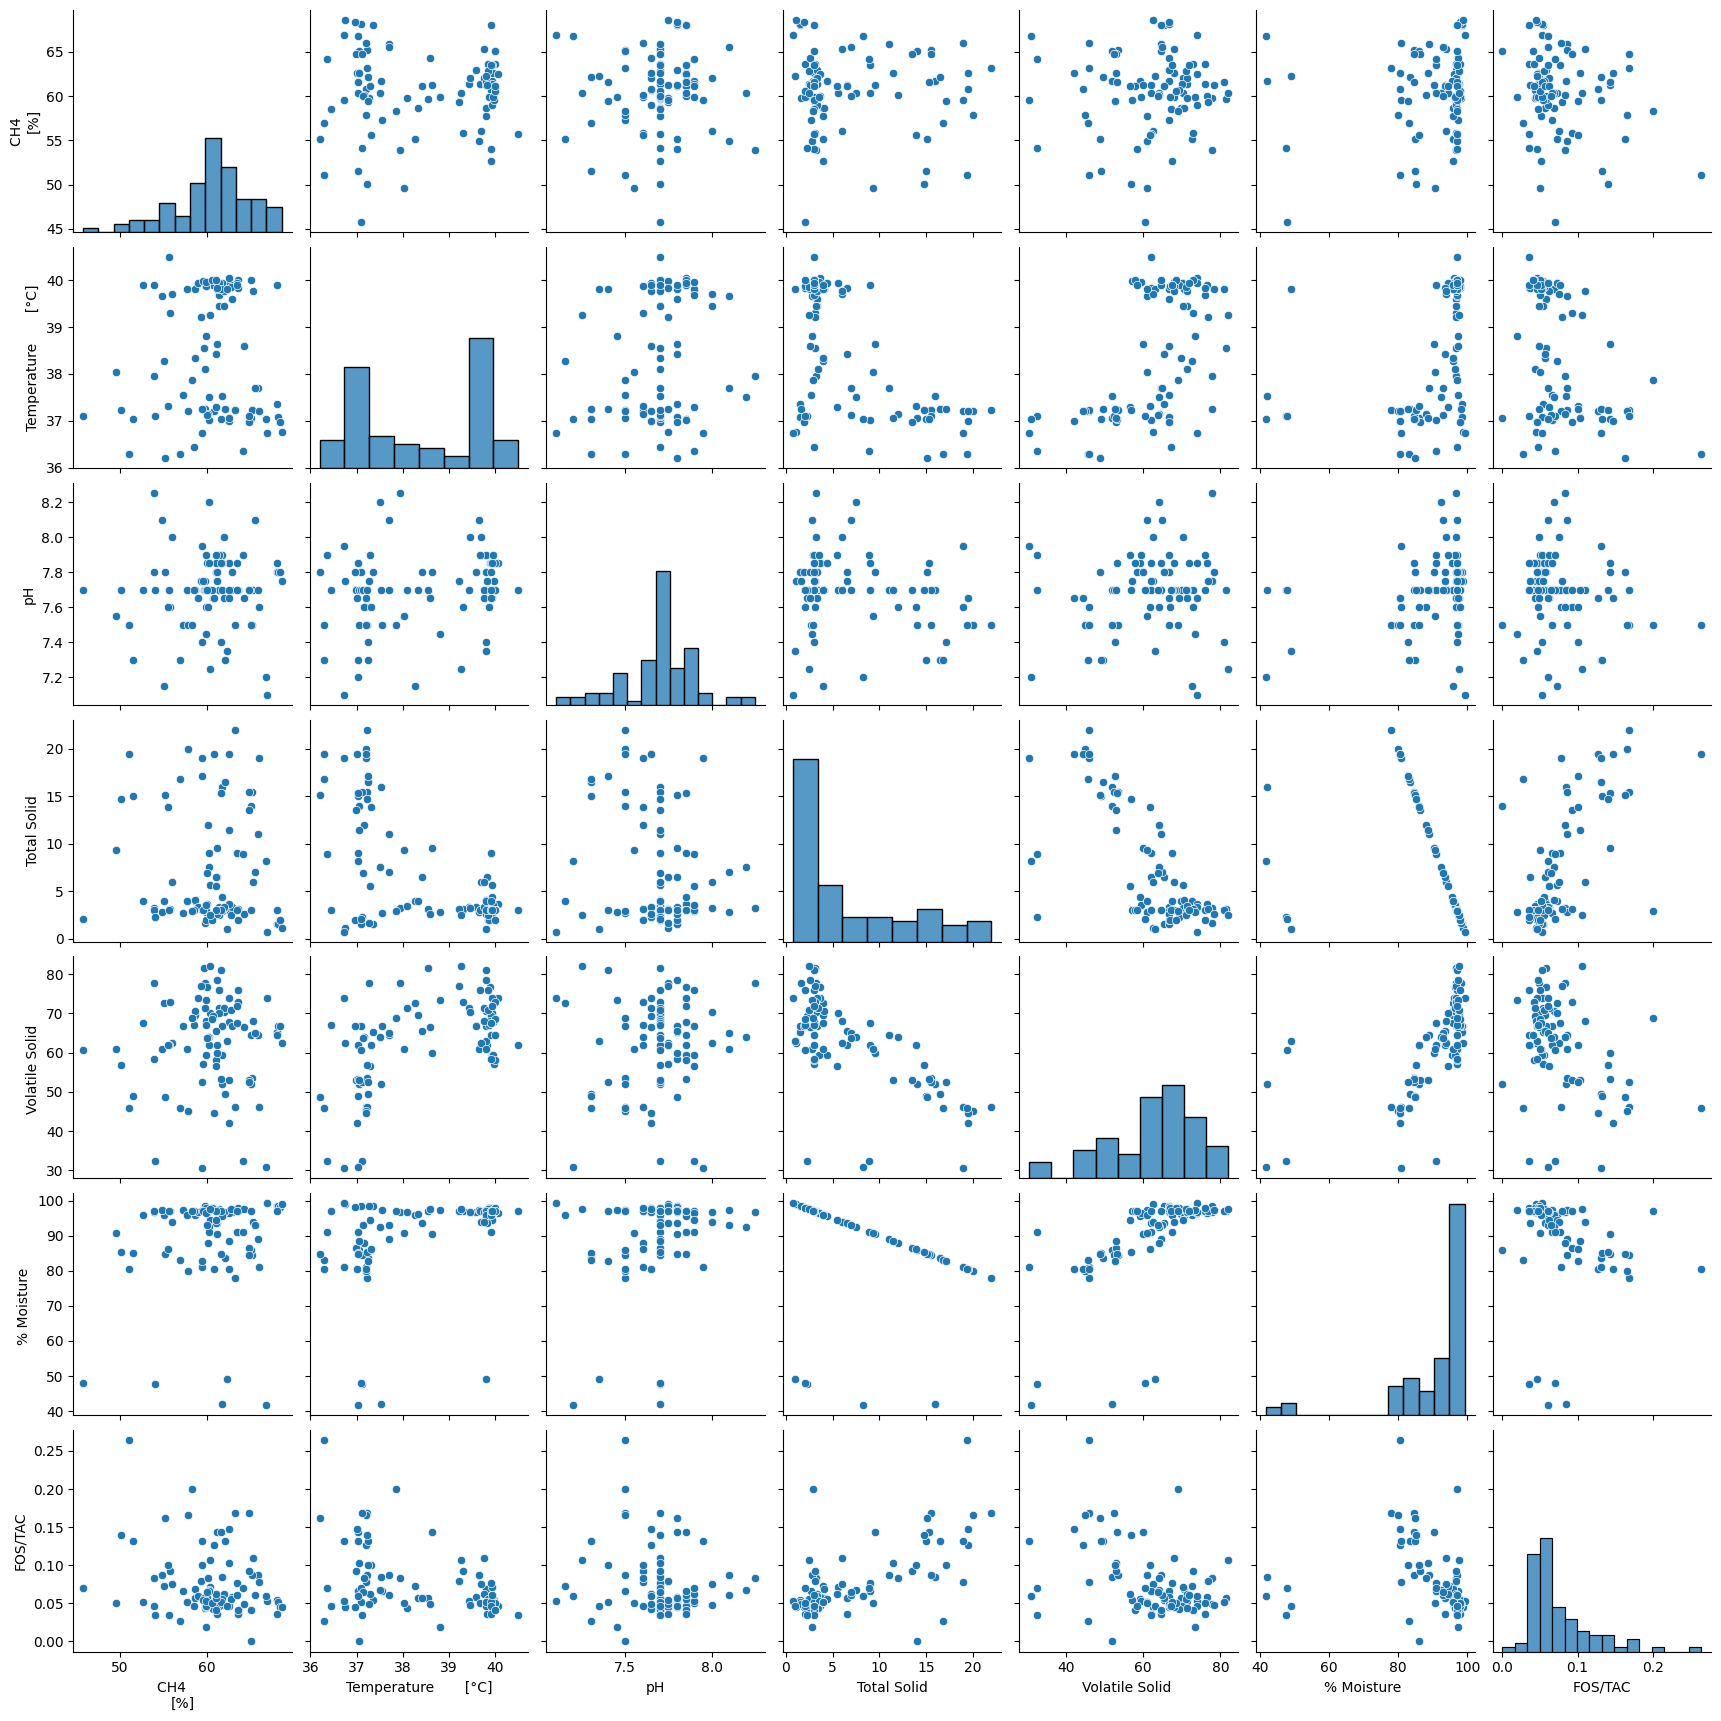

In [3]:
# Select the target variable and input features
target = df.columns[-1]
input_features = df.columns[:-1]

# Combine the target variable and input features into a single DataFrame
pairplot_data = pd.concat([df[target], df[input_features]], axis=1)

# Create a pairplot
sns.pairplot(pairplot_data, kind='scatter')
plt.show()

In [12]:

# Create a scatter plot
fig = px.scatter(df, x=input_features[0], y=target, title=f'Plot of Features Vs {df.columns[-1]}')

# Add the other five features to the plot
for feature in input_features[1:]:
    fig.add_scatter(x=df[feature], y=df[target], mode='markers', name=feature)
fig.update_layout(
    xaxis_title=""
)
fig.show()

In [6]:
# Create a pair plot
fig = px.scatter_matrix(df, dimensions=input_features, color=target,
                        title="Pair Plot of features Vs target variable", labels=input_features)

fig.update_layout(height=1000, width=1800)

# Adjust font size in layout
fig.update_layout(
    # title='Scatter Matrix Plot',
    title_font=dict(size=24),  # Set title font size
)

# Adjust tick font size
for axis in fig.layout:
    if isinstance(fig.layout[axis], dict) and 'tickfont' in fig.layout[axis]:
        fig.layout[axis]['tickfont']['size'] = 12  # Set tick font size

# Show the plot
fig.show()


<Axes: >

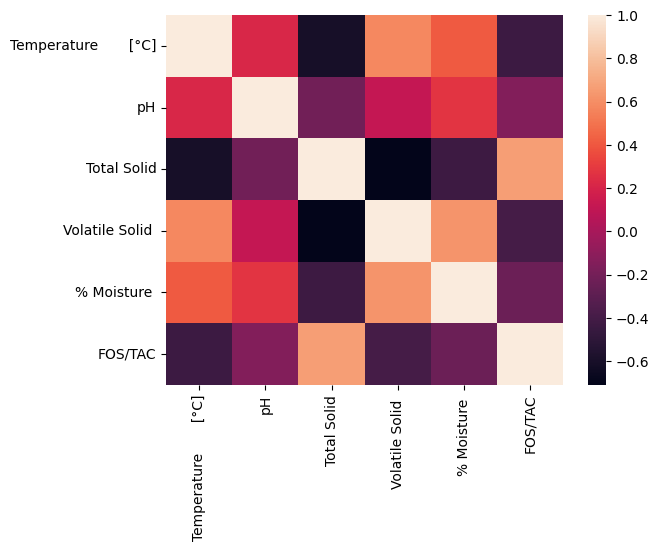

In [6]:
# Correlation Heatmap
corr = df.select_dtypes('number').drop(columns=df.columns[-1]).corr()

sns.heatmap(corr)

In [7]:
target = df.columns[-1]
y = df[target]
X = df.drop(columns=target)

In [8]:
# create a test split with 20% of test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [9]:
# create a validation split with 20% of val data
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [10]:
# Feature Scaling
from sklearn.preprocessing import StandardScaler

# Feature Scaling with StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

## Build Model

### Baseline

In [11]:
y_mean = y_train.mean()
y_pred_baseline = [y_mean] * len(y_train)
print("Mean target:", round(y_mean, 2))
print("Baseline MAE:", mean_absolute_error(y_train, y_pred_baseline))
print("Baseline r2:", r2_score(y_train, y_pred_baseline))

Mean target: 60.08
Baseline MAE: 3.1037517954610747
Baseline r2: 0.0


### Iterate

In [12]:
# Build Model with a decision tree regression algorithm (avoid multi-collinearity effect from 
# correlated features)
model = make_pipeline(
    # OrdinalEncoder(),
    DecisionTreeRegressor(max_depth=4, random_state=42)
)
# Fit model to training data
model.fit(X_train, y_train)

Pipeline(steps=[('decisiontreeregressor',
                 DecisionTreeRegressor(max_depth=4, random_state=42))])

## Evaluate

In [13]:
y_pred_training = model.predict(X_train)

print("Training MAE:", mean_absolute_error(y_train, y_pred_training))
print("Training r2:", r2_score(y_train, y_pred_training))

Training MAE: 2.0698699405205687
Training r2: 0.5371318531708958


In [14]:
mae_train = mean_absolute_error(y_train, model.predict(X_train))
mae_test = mean_absolute_error(y_test, model.predict(X_test))
mae_val = mean_absolute_error(y_val, model.predict(X_val))
r2_train = r2_score(y_train, model.predict(X_train))
r2_test = r2_score(y_test, model.predict(X_test))
r2_val = r2_score(y_val, model.predict(X_val))

print("Training MAE:", round(mae_train, 2), "Train R2", round(r2_train,2))
print("Test MAE:", round(mae_test, 2), "Test R2", round(r2_test,2))
print("Val MAE:", round(mae_val, 2), "Val R2", round(r2_val,2))

Training MAE: 2.07 Train R2 0.54
Test MAE: 3.0 Test R2 -0.98
Val MAE: 4.6 Val R2 -0.39


In [15]:
tree_depth = model.named_steps["decisiontreeregressor"].get_depth()
print("Tree Depth:", tree_depth)

Tree Depth: 4


In [16]:
# Create empty lists for training and validation MAE scores
training_mae = []
validation_mae = []
training_r2 = []
validation_r2 = []

for d in range(1,15):
    # Create model with `max_depth` of `d`
    test_model = make_pipeline(
        DecisionTreeRegressor(max_depth=d, random_state=42)
    )
    # Fit model to training data
    test_model.fit(X_train, y_train)
    # Calculate training accuracy score and append to `training_mae`
    training_mae.append(mean_absolute_error(test_model.predict(X_train), y_train))
    training_r2.append(r2_score(test_model.predict(X_train), y_train))
    # Calculate validation accuracy score and append to `training_mae`
    validation_mae.append(mean_absolute_error(test_model.predict(X_val), y_val))
    validation_r2.append(r2_score(test_model.predict(X_val), y_val))

print("Training MAE:", training_mae[:3], "Training R2", training_r2[:3])
print("Validation MAE:", validation_mae[:3], "Validation R2", validation_r2[:3])

Training MAE: [2.8904358353510884, 2.7628905717834624, 2.5970211864406774] Training R2 [-7.52473777651643, -2.738340984640055, -1.0610866038254523]
Validation MAE: [4.75207142857143, 4.5814814814814815, 5.25220833333333] Validation R2 [0.0, -15.492014654382025, -9.880523945239254]


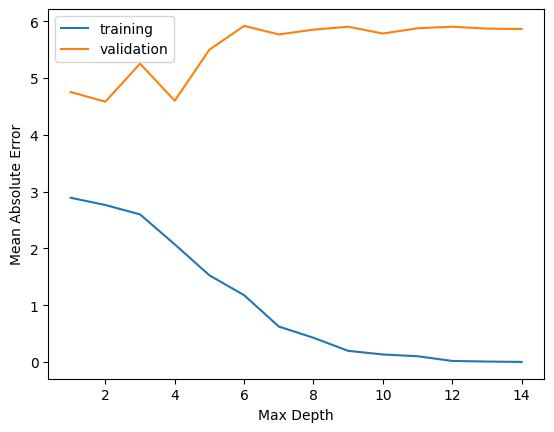

In [17]:
# Plot `depth_hyperparams`, `training_acc`
plt.plot(range(1,15), training_mae, label="training")
plt.plot(range(1,15), validation_mae, label="validation")
plt.xlabel("Max Depth")
plt.ylabel("Mean Absolute Error")
plt.legend();

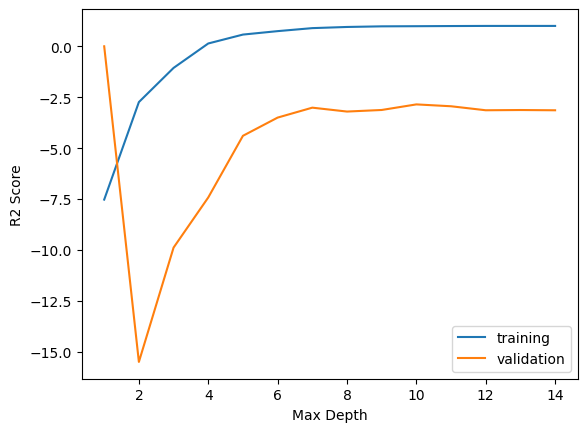

In [18]:
# Plot `depth_hyperparams`, `training_acc`
plt.plot(range(1,15), training_r2, label="training")
plt.plot(range(1,15), validation_r2, label="validation")
plt.xlabel("Max Depth")
plt.ylabel("R2 Score")
plt.legend();

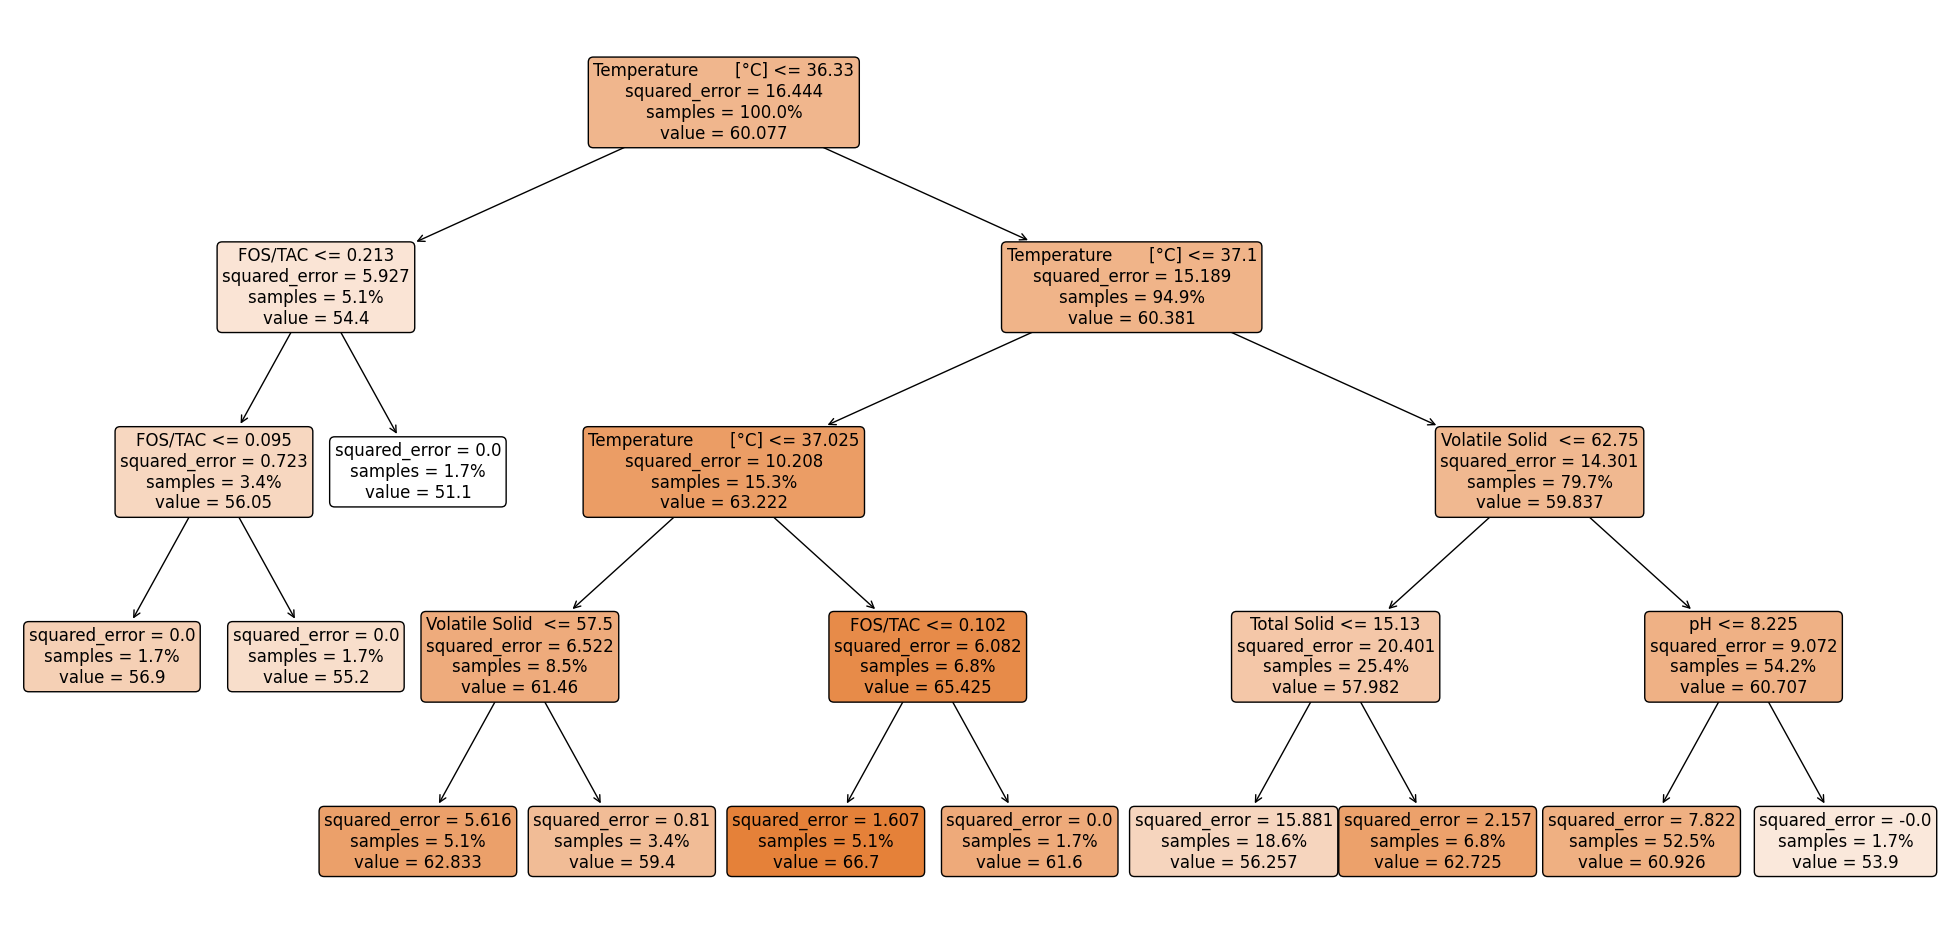

In [19]:
# Create larger figure
fig, ax = plt.subplots(figsize=(25, 12))
# Plot tree
plot_tree(
    decision_tree = model.named_steps["decisiontreeregressor"],
    feature_names=X_train.columns.to_list(),
    filled=True,  # Color leaf with class
    rounded=True,  # Round leaf edges
    proportion=True,  # Display proportion of classes in leaf
    max_depth=4,  # Only display first 3 levels
    fontsize=12,  # Enlarge font
    ax=ax,  # Place in figure axis
);

In [20]:
# Extract feature importances
features = X_train.columns
importances = model.named_steps["decisiontreeregressor"].feature_importances_

print("Features:", features[:3])
print("Importances:", importances[:3])

Features: Index(['Temperature       [°C]', 'pH', 'Total Solid'], dtype='object')
Importances: [0.42860317 0.09176874 0.23545918]


In [21]:
feat_imp = pd.Series(sorted(importances, reverse=False), index=features)
feat_imp.head()

Temperature       [°C]    0.000000
pH                        0.071551
Total Solid               0.091769
Volatile Solid            0.172618
% Moisture                0.235459
dtype: float64

Text(0, 0.5, 'Feature')

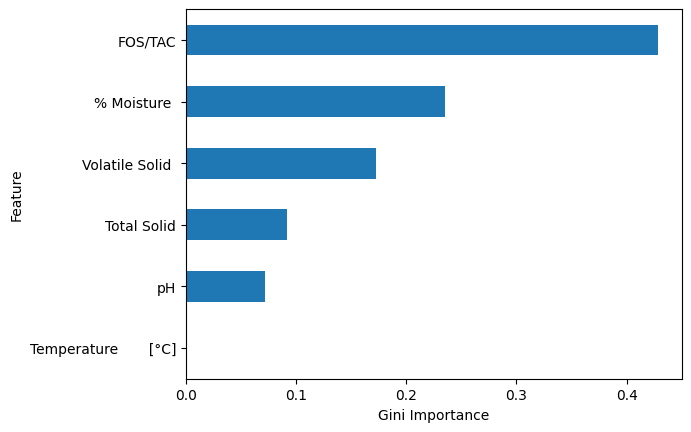

In [22]:
# Create horizontal bar chart
feat_imp.plot(kind="barh")
plt.xlabel("Gini Importance")
plt.ylabel("Feature")

In [23]:
# X_train.columns = ['temp', 'pH', 'ts', 'vs', 'moisture', 'ft']

In [26]:
def make_prediction(temp, pH, ts, vs, moisture, ft):
    data = {
        'Temperature       [°C]':temp,
        "pH":pH,
        'Total Solid':ts,
        'Volatile Solid ':vs,
        '% Moisture ': moisture,
        'FOS/TAC': ft
    }

    df = pd.DataFrame(data=data, index=[0])
    prediction = model.predict(df).round(2)[0]
    return f"Predicted CH4: {prediction}%"

In [27]:
interact(
    make_prediction,
    temp=FloatSlider(
        min=X_train['Temperature       [°C]'].min(),
        max=X_train['Temperature       [°C]'].max(),
        step=0.01,
        value=X_train['Temperature       [°C]'].mean(),
    ),
    pH=FloatSlider(
        min=X_train["pH"].min(),
        max=X_train["pH"].max(),
        step=0.01,
        value=X_train["pH"].mean(),
    ),
    ts=FloatSlider(
        min=X_train['Total Solid'].min(),
        max=X_train['Total Solid'].max(),
        step=0.01,
        value=X_train['Total Solid'].mean(),
    ),
    vs=FloatSlider(
        min=X_train['Volatile Solid '].min(),
        max=X_train['Volatile Solid '].max(),
        step=0.01,
        value=X_train['Volatile Solid '].mean(),
    ),
    moisture=FloatSlider(
        min=X_train['% Moisture '].min(),
        max=X_train['% Moisture '].max(),
        step=0.01,
        value=X_train['% Moisture '].mean(),
    ),
    ft=FloatSlider(
        min=X_train['FOS/TAC'].min(),
        max=X_train['FOS/TAC'].max(),
        step=0.01,
        value=X_train['FOS/TAC'].mean(),
    ),
);

interactive(children=(FloatSlider(value=38.49186440677967, description='temp', max=40.05, min=36.2, step=0.01)…